In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
ckpt   input_Conv   NN_Conv.ipynb  Trigo_NN_FC.ipynb
input  input_trigo  NN_FC.ipynb


Create dataloaders

In [0]:
from torch.utils.data import Dataset
from torchvision import transforms
import PIL
import os
import struct
import pandas as pd

class customDataset(Dataset):
  def __init__(self, path, transform=None):
    self.path = path
    self.file_list = os.listdir(path)
    self.transform = transform
    self.util = pd.read_csv('/content/drive/My Drive/Colab Notebooks/input_Conv/3UTIL.csv', header=None)[72]
    print(self.file_list)

  def __len__(self):
    return len(self.file_list)

  def getMean(self):
    return self.util.mean()

  def getStd(self):
    return self.util.std()

  def __getitem__(self, idx):
    img_file = open(self.path + self.file_list[idx], 'rb')
    bin_data = img_file.read()
    
    img = PIL.Image.frombytes('RGB', (105, 94), bin_data)
    if self.transform:
      img = self.transform(img)
    img_file.close()
    line = int(self.file_list[idx][:-4])
    val = (float(self.util.iloc[line]) - self.util.mean()) / self.util.std()

    return {'x': torch.Tensor(img), 'y': torch.Tensor([val])}

In [3]:
import numpy as np
import pandas
import random
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms, models

#random.seed(0)
#torch.manual_seed(0)
#np.random.seed(0)
#torch.cuda.manual_seed(0)
#torch.backends.cudnn.determenistic = True

path = '/content/drive/My Drive/Colab Notebooks/'

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

custom_transforms = transforms.Compose([
  transforms.Resize((224, 224), PIL.Image.BILINEAR),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

train_dataset = customDataset(path + 'input_Conv/train/', custom_transforms)
test_dataset = customDataset(path + 'input_Conv/test/', custom_transforms)
val_dataset =  customDataset(path + 'input_Conv/val/', custom_transforms)

['3.bin', '5.bin', '6.bin', '7.bin', '8.bin', '9.bin', '10.bin', '12.bin', '13.bin', '14.bin', '15.bin', '18.bin', '20.bin', '22.bin', '23.bin', '24.bin', '25.bin', '26.bin', '27.bin', '28.bin', '29.bin', '30.bin', '31.bin', '32.bin', '1.bin', '35.bin', '2.bin', '39.bin', '40.bin', '42.bin', '44.bin', '51.bin', '53.bin', '54.bin', '55.bin', '56.bin', '57.bin', '58.bin', '60.bin', '61.bin', '63.bin', '64.bin', '65.bin', '68.bin', '69.bin', '70.bin', '71.bin', '72.bin', '73.bin', '74.bin', '77.bin', '79.bin', '80.bin', '82.bin', '85.bin', '87.bin', '89.bin', '92.bin', '95.bin', '98.bin', '100.bin', '101.bin', '106.bin', '107.bin', '111.bin', '113.bin', '114.bin', '115.bin', '116.bin', '117.bin', '119.bin', '120.bin', '122.bin', '123.bin', '124.bin', '125.bin', '126.bin', '127.bin', '128.bin', '130.bin', '132.bin', '135.bin', '136.bin', '139.bin', '140.bin', '145.bin', '147.bin', '148.bin', '150.bin', '153.bin', '154.bin', '155.bin', '156.bin', '157.bin', '158.bin', '160.bin', '161.bin', 

In [0]:
batch_size = 60
train_dataloader = torch.utils.data.DataLoader(
  train_dataset, batch_size=batch_size, shuffle=True, num_workers=8,
  drop_last = True
)
val_dataloader = torch.utils.data.DataLoader(
  val_dataset, batch_size=batch_size, shuffle=False, num_workers=8,
  drop_last = True
)
test_dataloader = torch.utils.data.DataLoader(
  test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, 
  drop_last = True
)

In [5]:
print(len(train_dataloader), len(train_dataset))
print(len(val_dataloader), len(val_dataset))
print(len(test_dataloader), len(test_dataset))

9 540
3 180
3 180


Show image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


util tensor([0.1290])
torch.Size([3, 224, 224])


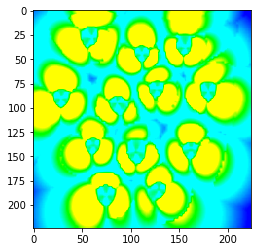

In [6]:
def show_img(dataset, idx):
  sample = dataset.__getitem__(idx)
  img = sample['x']
  print('util', sample['y'])
  #img[0] = img[0] * std[0] + mean[0]
  #img[1] = img[1] * std[1] + mean[1]
  #img[2] = img[2] * std[2] + mean[2]
  print(img.shape)
  plt.imshow(img.permute(1, 2, 0).numpy())

show_img(train_dataset, 1)

In [0]:
list_loss_val = []
list_loss_train = []

import time

def train_model(name, model, loss, optimizer, scheduler, num_epochs):
  for epoch in range(num_epochs):
    if ((epoch + 1) % 2 == 0):
      torch.save(model.state_dict(), path + "ckpt/" + name + "/" + str(epoch) + ".ckpt")
    print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
    
    for phase in ['train', 'val']:
      tot_loss = 0.0
      if phase == 'train':
        dataloader = train_dataloader
        #scheduler.step()
        model.train()
      else:
        dataloader = val_dataloader
        model.eval()

      for idx, batch in enumerate(dataloader):
        t00 = time.time()
        print('Batch #' + str(idx), flush=True)
        args = batch['x'].to(device)
        val = batch['y'].to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          t0 = time.time()
          inference = model(args)
          t1 = time.time()
          print(t1 - t0)
          loss_value = loss(inference, val.reshape(batch_size, 1))
          tot_loss += loss_value.item()
          
        if phase == 'train':
          t0 = time.time()
          loss_value.backward()
          t1 = time.time()
          print(t1 - t0)
          optimizer.step()
      
      t11 = time.time()
      print(t11 - t00)
      if phase =='train':
        list_loss_train.append(tot_loss / batch_size)
      else:
        list_loss_val.append(tot_loss / batch_size)
      print('{} Loss: {:.4f} '.format(phase, tot_loss / batch_size , flush=True))
  return model

Create custom model

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

name = 'Resnet18_mlab_3'
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 1)
model = model.to(device)

num_epochs = 60
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-4, momentum = 0.95)

# Decay LR by a factor of 0.5 every 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
print('model was created')

loss = torch.nn.MSELoss()
os.mkdir(path + "ckpt/" + name)

model was created


FileExistsError: ignored

In [10]:
train_model(name, model, loss, optimizer, scheduler, num_epochs)

Epoch 0/59:
Batch #0
5.428996801376343
0.006290912628173828
Batch #1
4.779357194900513
0.00040149688720703125
Batch #2
4.808847427368164
0.0003275871276855469
Batch #3
4.681138515472412
0.00030994415283203125
Batch #4
4.900179862976074
0.0004782676696777344
Batch #5
4.816346645355225
0.0004105567932128906
Batch #6
4.834453821182251
0.0007774829864501953
Batch #7
4.770035028457642
0.00034546852111816406
Batch #8
4.751546859741211
0.0003809928894042969
4.799097537994385
train Loss: 0.1546 
Batch #0
3.971345901489258
Batch #1
3.4721760749816895
Batch #2
3.5307300090789795
3.6009461879730225
val Loss: 0.0742 
Epoch 1/59:
Batch #0
5.923804759979248
0.00039768218994140625
Batch #1
4.837202310562134
0.00048732757568359375
Batch #2
4.794626951217651
0.0004074573516845703
Batch #3
4.861774682998657
0.0003662109375
Batch #4
4.695188283920288
0.00045013427734375
Batch #5
4.8015501499176025
0.0006096363067626953
Batch #6
4.748913764953613
0.00035452842712402344
Batch #7
4.820819616317749
0.0005724

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
file = open(path + 'ckpt' + '/' + name + '/loss_val', 'w')
for val in list_loss_val:
  file.write(str(val) + '\n')
file.close()

file = open(path + 'ckpt' + '/' + name + '/loss_train', 'w')
for val in list_loss_train:
  file.write(str(val) + '\n')
file.close()

Loss on test

In [12]:
import math

model.eval()
state_dict = torch.load(path + "ckpt/" + "Resnet18_mlab_3/59" + ".ckpt") 
model.load_state_dict(state_dict)
target_list = torch.Tensor(len(test_dataloader), batch_size)
inference_list = torch.Tensor(len(test_dataloader), batch_size)

dataloader = test_dataloader
loss_value = 0.0
for idx, batch in enumerate(dataloader):
  args = batch['x'].to(device)
  val = batch['y'].to(device)

  inference = model(args)
  target_list[idx] = val.reshape(-1) * test_dataset.getStd() + test_dataset.getMean()
  inference_list[idx] = inference.reshape(-1) * train_dataset.getStd() + train_dataset.getMean()
  loss_value += loss(inference_list[idx], target_list[idx]).item()

loss_value /= len(test_dataloader)
loss_value = math.sqrt(loss_value)
print('Test Loss: {:f} '.format(loss_value, flush=True))

Test Loss: 0.012159 


Draw inference(target) Test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: numpy.arange
  """


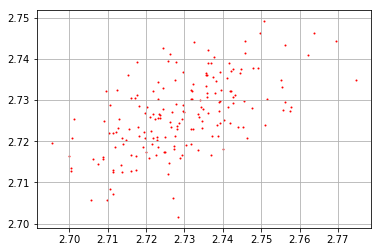

In [13]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

my_fig = plt.figure()
x_lin = mlab.frange(-4800.0, 100.0, -4200.0)
plt.plot(x_lin, x_lin)

target_list.reshape(1, -1)[0].detach().numpy()
inference_list.reshape(1, -1)[0].detach().numpy()

for i in range(len(target_list)):
  plt.scatter(target_list[i], inference_list[i].detach().numpy(), c = 'red', s = 1)

plt.grid()

Loss on train 

In [14]:
target_list = torch.Tensor(len(train_dataloader), batch_size)
inference_list = torch.Tensor(len(train_dataloader), batch_size)

dataloader = train_dataloader
loss_value = 0.0
for idx, batch in enumerate(dataloader):
  args = batch['x'].to(device)
  val = batch['y'].to(device)

  inference = model(args)
  target_list[idx] = val.reshape(-1) * train_dataset.getStd() + train_dataset.getMean()
  inference_list[idx] = inference.reshape(batch_size) * train_dataset.getStd() + train_dataset.getMean()
  loss_value += loss(inference_list[idx], target_list[idx])

loss_value /= len(train_dataloader)
loss_value = math.sqrt(loss_value)
print('Train Loss: {:.4f} '.format(loss_value, flush=True))

Train Loss: 0.0097 


Draw inference(target) train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: numpy.arange
  


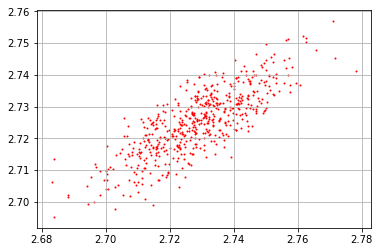

In [15]:
my_fig = plt.figure()
x_lin = mlab.frange(-4800.0, 100.0, -4200.0)
plt.plot(x_lin, x_lin)

target_list.reshape(1, -1)[0].detach().numpy()
inference_list.reshape(1, -1)[0].detach().numpy()

for i in range(len(target_list)):
  plt.scatter(target_list[i], inference_list[i].detach().numpy(), c = 'red', s = 1)

plt.grid()

Loss(epochs) on train

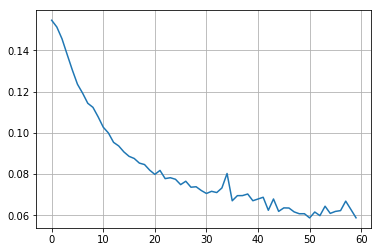

In [17]:
my_fig = plt.figure()

x = [i for i in range(num_epochs)]
y = []

file = open(path + 'ckpt' + '/' + name + '/loss_train', 'r')
for val in file:
  y.append(float(val))
file.close()

plt.plot(x, y)

plt.grid()

Loss(epochs) on validation

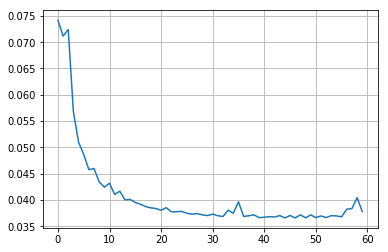

In [19]:
my_fig = plt.figure()

x = [i for i in range(num_epochs)]
y = []

file = open(path + 'ckpt' + '/' + name + '/loss_val', 'r')
for val in file:
  y.append(float(val))
file.close()

plt.plot(x, y)

plt.grid()